In [82]:
# !pip install gymnasium
# !pip install gymnasium[toy-text]
# !pip install tqdm #just for progress bar
# !pip install icecream #just for debugging

In [83]:
from icecream import ic #Just for debugging

#check version
import gymnasium as gym
print(f'Gymnasium v{gym.__version__}') #Gymnasium v0.29.0
import sys; print(f'Python v{sys.version}') #Python v3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

import numpy as np
from collections import defaultdict

from IPython.display import clear_output
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics
import matplotlib.pyplot as plt

#create env
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array') #specific map
#env=gym.make('Blackjack-v1',render_mode='rgb_array')
#env=gym.make('CliffWalking-v0',render_mode='rgb_array')
#env=gym.make('Taxi-v3',render_mode='rgb_array')

done=False
observation, info = env.reset()

Gymnasium v0.29.0
Python v3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [84]:
# #Just some manual tests
# import matplotlib.pyplot as plt
# if terminated or truncated:
#     env.reset()
# obs, reward, terminated, truncated, info =env.step(1)
# print(obs)
# print(reward)

# img=env.render()
# fig, ax=plt.subplots()
# ax.imshow(img)
# ax.set_title('Game')
# ax.axis('off')
# plt.show()

In [85]:
import numpy as np
from collections import defaultdict

from IPython.display import clear_output
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics
import matplotlib.pyplot as plt

class TD_zero_for_Qvalue:
    def __init__(
        self,
        learning_rate: float=0.01,
        initial_epsilon: float=1,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float=0.95,
        n_episodes: int=10000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env_stat.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.n_episodes = n_episodes
        self.env_stat = env_stat
        self.training_error = []

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return self.env_stat.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(self, obs, action, reward, terminated, next_obs):
        """Updates the Q-values with Temporal Difference"""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def linear_decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def exponential_decay(self):
        self.epsilon = self.epsilon * self.epsilon_decay

    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False

            # Play one episode
            while not done:
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)

                # Update agent policy at each step
                self.update(obs, action, reward, terminated, next_obs)
                done = terminated or truncated
                obs = next_obs

                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached

            self.linear_decay()

    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        title = "TD method: learning_rate=" + str(self.lr) + ", discount_factor=" + str(self.discount_factor)
        plt.suptitle(title)
        plt.tight_layout()
        title2="TD_"+ str(self.lr)+ "_"+ str(self.discount_factor)+ ".png"
        plt.savefig(title2)
        plt.show()


In [86]:
class Expected_SARSA:
    def __init__(
        self,
        learning_rate: float=0.01,
        initial_epsilon: float=1,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float = 0.95,
        n_episodes: int=10000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda: np.zeros(env.action_space.n)) #everytime new statevalue added the lambda function is called to create a np vector of q values (initialized to zero)
        self.lr = learning_rate #the bigger the more oscillations q_values
        self.discount_factor = discount_factor 
        self.epsilon = initial_epsilon 
        self.epsilon_decay = epsilon_decay #linear decay until reaches final_epsilon
        self.final_epsilon = final_epsilon #approximately zero 
        self.n_episodes= n_episodes
        self.env_stat=env_stat
        self.training_error=[] #temporale differences (when small, no further improvements)
    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random()<self.epsilon:
            return self.env_stat.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    def update(self, obs, action, reward, next_obs,  terminated):
        """Updates the Q-values with EXPECTED-SARSA rule by probabilities given by the policy"""
        expected_value = sum(
         ((1 - self.epsilon + self.epsilon / self.env_stat.action_space.n) if a == int(np.argmax(self.q_values[next_obs])) else self.epsilon / self.env_stat.action_space.n)
            * self.q_values[next_obs][a]
                  for a in range(self.env_stat.action_space.n)
                    ) / self.env_stat.action_space.n

        self.q_values[obs][action]=self.q_values[obs][action] + self.lr*(reward+self.discount_factor*expected_value-self.q_values[obs][action])
        self.training_error.append(reward+self.discount_factor*expected_value-self.q_values[obs][action]) 
    def linear_decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    def exponential_decay(self): 
        self.epsilon= self.epsilon*self.epsilon_decay   
    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False
            action = self.get_action(obs)
            # play one episode
            while not done:
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)
                #update agent policy at each step
                self.update(obs, action, reward, next_obs, terminated)
                done= terminated or truncated
                obs=next_obs
                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached
            self.linear_decay()
            #ic(self.epsilon)
    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        title= "Expected SARSA: learning_rate= "+ str(self.lr) + ", discount_factor= " + str(self.discount_factor)
        plt.suptitle(title)
        plt.tight_layout()
        title2="E_sarsa"+ str(self.lr)+ "_"+ str(self.discount_factor)+ ".png"
        plt.savefig(title2)
        plt.show()

In [87]:
class SARSA:
    def __init__(
        self,
        learning_rate: float=0.01,
        initial_epsilon: float=1,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float = 0.95,
        n_episodes: int=10000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda: np.zeros(env.action_space.n)) #everytime new statevalue added the lambda function is called to create a np vector of q values (initialized to zero)
        self.lr = learning_rate #the bigger the more oscillations q_values
        self.discount_factor = discount_factor 
        self.epsilon = initial_epsilon 
        self.epsilon_decay = epsilon_decay #linear decay until reaches final_epsilon
        self.final_epsilon = final_epsilon #approximately zero 
        self.n_episodes= n_episodes
        self.env_stat=env_stat
        self.training_error=[] #temporale differences (when small, no further improvements)
    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random()<self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    def update(self, obs, action, reward, next_obs, next_action,  terminated):
        """Updates the Q-values with SARSA"""

        self.q_values[obs][action]=self.q_values[obs][action] + self.lr*(reward+self.discount_factor*self.q_values[next_obs][next_action]-self.q_values[obs][action])
        self.training_error.append(reward+self.discount_factor*self.q_values[next_obs][next_action]-self.q_values[obs][action]) 
    def linear_decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    def exponential_decay(self): 
        self.epsilon= self.epsilon*self.epsilon_decay

        
    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False
            action = self.get_action(obs)
            # play one episode
            while not done:
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)
                next_action = self.get_action(next_obs)
                #update agent policy at each step
                self.update(obs, action, reward, next_obs, next_action, terminated)
                done= terminated or truncated
                obs=next_obs
                action=next_action
                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached
            self.linear_decay()
            #ic(self.epsilon)

    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)
        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        title= "SARSA: learning_rate= "+ str(self.lr) + ", discount_factor= " + str(self.discount_factor)
        plt.suptitle(title)
        plt.tight_layout()
        title2="SARSA_"+ str(self.lr)+ "_"+ str(self.discount_factor)+ ".png"
        plt.savefig(title2)
        plt.show()

In [88]:
class constant_learning_rate_MC:
    def __init__(
        self,
        learning_rate: float=0.99,
        initial_epsilon: float=0.0001,
        epsilon_decay: float=0.0001,
        final_epsilon: float=0.0001,
        discount_factor: float = 0.95,
        n_episodes: int=3000,
        env_stat: RecordEpisodeStatistics=env,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values=defaultdict(lambda: np.zeros(env.action_space.n)) #everytime new statevalue added the lambda function is called to create a np vector of q values (initialized to zero)
        self.lr = learning_rate #the bigger the more oscillations q_values
        self.discount_factor = discount_factor 
        self.epsilon = initial_epsilon 
        self.epsilon_decay = epsilon_decay #linear decay until reaches final_epsilon
        self.final_epsilon = final_epsilon #approximately zero 
        self.n_episodes= n_episodes
        self.obs_traj=[]
        self.action_traj=[]
        self.reward_traj=[]
        self.env_stat=env_stat
        self.training_error=[] #temporale differences (when small, no further improvements expected)

    def get_action(self, obs) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random()<self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))

    def linear_decay(self):
        self.epsilon=max(self.final_epsilon, self.epsilon-self.epsilon_decay)
    def exponential_decay(self): 
        self.epsilon= self.epsilon*self.epsilon_decay


    def update_traj(self, obs, action, reward, terminated):
        """Append new obs, action, reward. When terminated, update policy and trash the episode"""
        self.action_traj.append(action)
        self.reward_traj.append(reward)
        self.obs_traj.append(obs)
        #ic(obs)
        if terminated:
            self.update_policy()           
            self.obs_traj=[]
            self.action_traj=[]
            self.reward_traj=[] 
    def update_policy(self):
        """Updates the Q-values from last episode using the following:
                Q(S_t, A_t)<- Q(S_t, A_t) + learning_rate*(G_t-Q(S_t,A_t)),
                where G_t is the return at time-step t.
        """
        G=0
        sum=0
        visited=[]
        for obs, action, reward in reversed(list(zip(self.obs_traj, self.action_traj, self.reward_traj))):
            G= self.discount_factor*G + reward
            #Update once per episode
            if (obs, action) not in visited:
                self.q_values[obs][action]= self.q_values[obs][action] + self.lr*(G - self.q_values[obs][action])
                visited.append((obs,action))
                sum+=abs(G - self.q_values[obs][action])
            #ic(visited)
        #if any(self.q_values[15]):
        #    ic(self.q_values[15])
        self.training_error.append(sum/len(visited))
    
    def train(self):
        for episode in tqdm(range(self.n_episodes)):
            obs, info = self.env_stat.reset()
            done = False
            # play one episode
            while not done:
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env_stat.step(action)

                #update_traj at each step and update policy at the end
                self.update_traj(next_obs, action, reward, terminated)
                done= terminated or truncated
                obs=next_obs
                if info.get('TimeLimit.truncated', False):
                    done = True  # Terminate the episode if max episode steps are reached
            self.linear_decay()
            #ic(self.epsilon)
            #ic(self.q_values[0])
   
    def plot(self, rolling_length=100):
        fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
        axs[0].set_title("Episode rewards")
        reward_moving_average = (
            np.convolve(
                np.array(self.env_stat.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

        axs[1].set_title("Episode lengths")
        length_moving_average = (
            np.convolve(
                np.array(self.env_stat.length_queue).flatten(), np.ones(rolling_length), mode="same"
            )
            / rolling_length
        )
        axs[1].plot(range(len(length_moving_average)), length_moving_average)

        axs[2].set_title("Training Error")
        training_error_moving_average = (
            np.convolve(np.array(self.training_error), np.ones(rolling_length), mode="same")
            / rolling_length
        )
        axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
        
        title= "Constant Learning Rate Montecarlo: learning_rate= "+ str(self.lr)
        plt.suptitle(title)
        plt.tight_layout()
        title2="MC_"+ str(self.lr)+".png"
        plt.savefig(title2)
        plt.show()

In [89]:
#env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='rgb_array') #specific map
env=gym.make('Blackjack-v1',render_mode='rgb_array')
#env=gym.make('CliffWalking-v0',render_mode='rgb_array')
#env=gym.make('Taxi-v3',render_mode='rgb_array')

done=False
observation, info = env.reset()


#hyperparameters
learning_rate = 0.01
n_episodes = 50000
start_epsilon = 1.0
final_epsilon = 0.001
epsilon_decay = start_epsilon/n_episodes  # reduce the exploration over time linearly
discount_factor=0.99
#epsilon_decay= final_epsilon**(1/n_episodes) #with n_episodes updates epsilon reaches 0.000001


# Define the maximum number of steps per episode
max_episode_steps = 200

from gym.wrappers import TimeLimit
# Wrap the environment with the TimeLimit wrapper
env = TimeLimit(env, max_episode_steps=max_episode_steps)

env_stat = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

/home/cristian/.local/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


In [90]:
# learning_rates = [0.5, 0.8, 0.9, 0.95, 0.99]
# discount_factors = [0.8, 0.95, 0.99]
# for learning_rate in learning_rates:
#     for discount_factor in discount_factors:
#         agentsarsa=TD_zero_for_Qvalue(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_sarsa=SARSA(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_E_sarsa=Expected_SARSA(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_MC=constant_learning_rate_MC(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)

#         agentsarsa.train()
#         agentsarsa.plot(1000)


#         agent_sarsa.train()
#         agent_sarsa.plot(1000)


#         agent_E_sarsa.train()
#         agent_E_sarsa.plot(1000)


#     agent_MC.train()
#     agent_MC.plot(1000)

In [91]:
# learning_rates = [0.5, 0.8, 0.9, 0.95, 0.99]
# discount_factors = [0.8, 0.95, 0.99]
# for learning_rate in learning_rates:
#     for discount_factor in discount_factors:
#         agentsarsa=TD_zero_for_Qvalue(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_sarsa=SARSA(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_E_sarsa=Expected_SARSA(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
#         agent_MC=constant_learning_rate_MC(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)

#         agentsarsa.train()
#         agentsarsa.plot(1000)


#         agent_sarsa.train()
#         agent_sarsa.plot(1000)


#         agent_E_sarsa.train()
#         agent_E_sarsa.plot(1000)


#     agent_MC.train()
#     agent_MC.plot(1000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:13<00:00, 7301.53it/s]


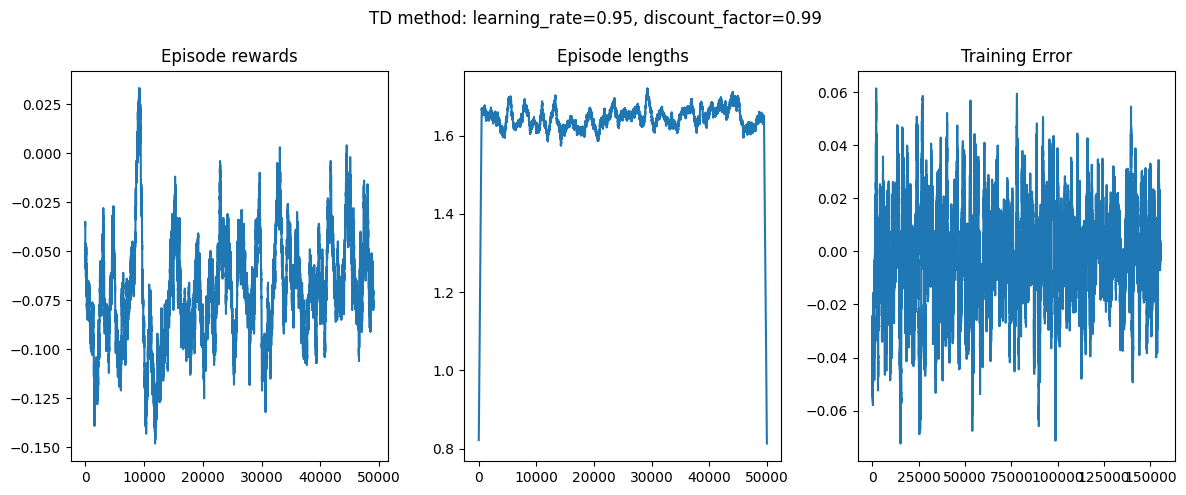

100%|██████████| 100000/100000 [00:13<00:00, 7455.33it/s]


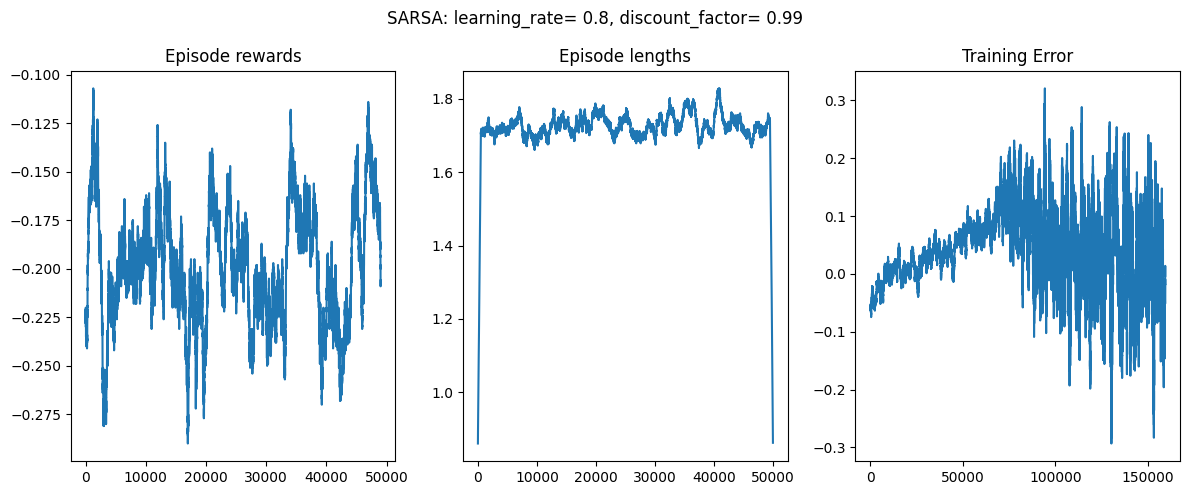

100%|██████████| 50000/50000 [00:06<00:00, 7687.46it/s]


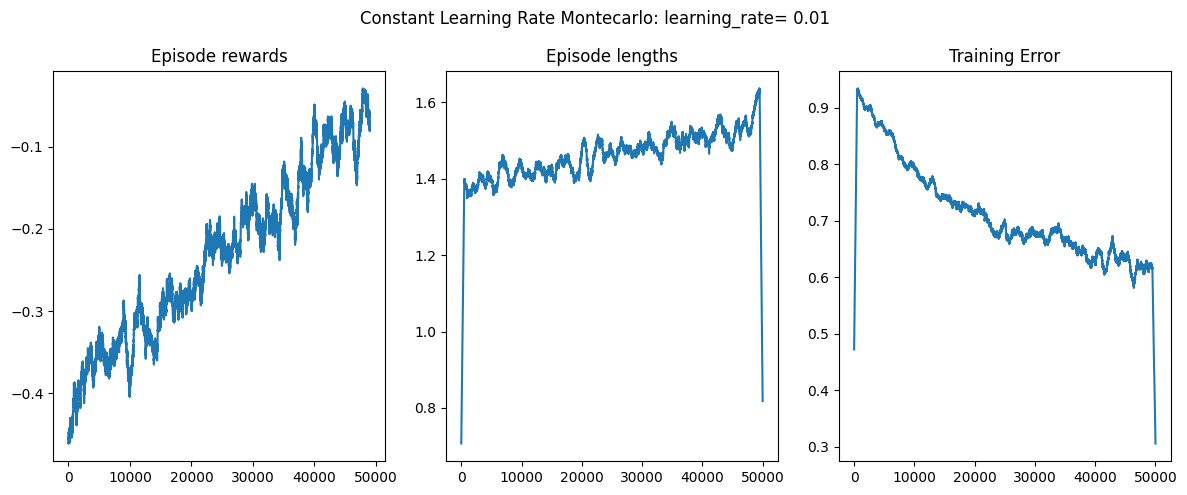

In [92]:
agent_TD=TD_zero_for_Qvalue(
    n_episodes=100000,
    learning_rate=0.95,
    discount_factor=0.99,
    initial_epsilon=1,
    epsilon_decay=1/50000,
    final_epsilon=0.001,
    env_stat=env_stat)
agent_sarsa=SARSA(
    n_episodes=100000,
    learning_rate=0.8,
    discount_factor=0.99,
    initial_epsilon=start_epsilon,
    epsilon_decay=1/50000,
    final_epsilon=final_epsilon,
    env_stat=env_stat,)
#         agent_E_sarsa=Expected_SARSA(
#     n_episodes=n_episodes,
#     learning_rate=learning_rate,
#     discount_factor=discount_factor,
#     initial_epsilon=start_epsilon,
#     epsilon_decay=epsilon_decay,
#     final_epsilon=final_epsilon,
#     env_stat=env_stat,)
agent_MC=constant_learning_rate_MC(
    n_episodes=n_episodes,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    env_stat=env_stat,)

agent_TD.train()
agent_TD.plot(1000)


agent_sarsa.train()
agent_sarsa.plot(1000)


#         agent_E_sarsa.train()
#         agent_E_sarsa.plot(1000)


agent_MC.train()
agent_MC.plot(1000)

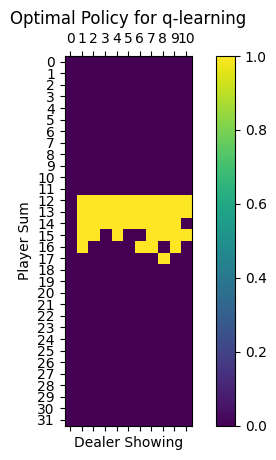

In [100]:
# Assuming you have already created the grid as mentioned in your code snippet
grid = np.zeros((32, 11))

# Replace this loop with your own logic to populate the grid
for player, dealer, bool_value in agent_TD.q_values.keys():
    if bool_value == 1:
        action = int(agent_TD.q_values[(player, dealer, 0)][1] > agent_TD.q_values[(player, dealer, 0)][0])
        grid[player][dealer] = action

# Create a heatmap using Matplotlib
fig, ax = plt.subplots()

cax = ax.matshow(grid, cmap='viridis')

plt.colorbar(cax)

ax.set_xticks(range(11))
ax.set_yticks(range(32))

ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
plt.title('Optimal Policy for q-learning')

plt.show()

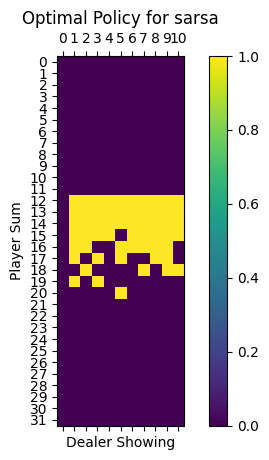

In [101]:
# Assuming you have already created the grid as mentioned in your code snippet
grid = np.zeros((32, 11))

# Replace this loop with your own logic to populate the grid
for player, dealer, bool_value in agent_TD.q_values.keys():
    if bool_value == 1:
        action = int(agent_sarsa.q_values[(player, dealer, 0)][1] > agent_TD.q_values[(player, dealer, 0)][0])
        grid[player][dealer] = action

# Create a heatmap using Matplotlib
fig, ax = plt.subplots()

cax = ax.matshow(grid, cmap='viridis')

plt.colorbar(cax)

ax.set_xticks(range(11))
ax.set_yticks(range(32))

ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
plt.title('Optimal Policy for sarsa')

plt.show()

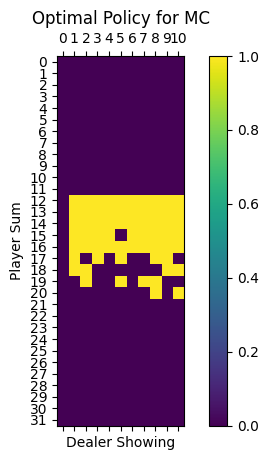

In [102]:
# Assuming you have already created the grid as mentioned in your code snippet
grid = np.zeros((32, 11))

# Replace this loop with your own logic to populate the grid
for player, dealer, bool_value in agent_TD.q_values.keys():
    if bool_value == 1:
        action = int(agent_MC.q_values[(player, dealer, 0)][1] > agent_TD.q_values[(player, dealer, 0)][0])
        grid[player][dealer] = action

# Create a heatmap using Matplotlib
fig, ax = plt.subplots()

cax = ax.matshow(grid, cmap='viridis')

plt.colorbar(cax)

ax.set_xticks(range(11))
ax.set_yticks(range(32))

ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
plt.title('Optimal Policy for MC')

plt.show()

In [96]:
# #Frozen lake
# fig, ax = plt.subplots()

# obs, info = env_stat.reset()
# done = False
# terminated=False
# truncated=False
# for i in range(20):
#     done= terminated or truncated
#     if done:
#         obs, info = env_stat.reset()
#     img=env_stat.render()
#     ax.imshow(img)
#     action = agent_sarsa.get_action(obs)
#     if action==0:
#         title= "sarsa policy action: left"
#         ax.set_title(title)
#     if action==1:
#         title="sarsa policy action: down"
#         ax.set_title(title)
#     if action==2:
#         title="sarsa policy action: right"
#         ax.set_title(title)
#     if action==3:
#         title= "sarsa policy action: up"
#         ax.set_title(title)
#     next_obs, reward, terminated, truncated, info = env_stat.step(action)
#     obs=next_obs
#     plt.savefig("sarsa_lake-"+str(i))
# plt.show()

In [97]:
# #Cliff
# #[0,0], [0,1], ... ,[0,11]
# #[1,0]
# #
# #[3,0], [3,1], ... ,[3,11]
# fig, ax = plt.subplots()

# obs, info = env_stat.reset()
# done = False
# terminated=False
# truncated=False
# for i in range(20):
#     done= terminated or truncated
#     if done:
#         obs, info = env_stat.reset()
#     img=env_stat.render()
#     ax.imshow(img)
#     action = agent_sarsa.get_action(obs)
#     if action==0:
#         title= "sarsa policy action: up"
#         ax.set_title(title)
#     if action==1:
#         title="sarsa policy action: right"
#         ax.set_title(title)
#     if action==2:
#         title="sarsa policy action: down"
#         ax.set_title(title)
#     if action==3:
#         title= "sarsa policy action: left"
#         ax.set_title(title)
#     next_obs, reward, terminated, truncated, info = env_stat.step(action)
#     obs=next_obs
#     plt.savefig("sarsa_cliff-"+str(i))
# plt.show()

In [98]:
# # #Taxi
# # #Obs space: ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

# fig, ax = plt.subplots()

# obs, info = env_stat.reset()
# done = False
# terminated=False
# truncated=False
# for i in range(20):
#     done= terminated or truncated
#     if done:
#         obs, info = env_stat.reset()
#     img=env_stat.render()
#     ax.imshow(img)
#     action = agent_sarsa.get_action(obs)
#     if action==0:
#         title= "sarsa policy action: down"
#         ax.set_title(title)
#     if action==1:
#         title="sarsa policy action: up"
#         ax.set_title(title)
#     if action==2:
#         title="sarsa policy action: right"
#         ax.set_title(title)
#     if action==3:
#         title= "sarsa policy action: left"
#     ax.set_title(title)
#     if action==4:
#         title= "sarsa policy action: pickup passenger"
#         ax.set_title(title)
#     if action==5:
#         title= "sarsa policy action: drop off passenger"
#         ax.set_title(title)
#     next_obs, reward, terminated, truncated, info = env_stat.step(action)
#     obs=next_obs
#     plt.savefig("sarsa_taxi-"+str(i))
# plt.show()

In [99]:
# #Blackjack
# #Obs space: (player sum, dealer showing card, usable ace (always 11 unless busts))


# fig, ax = plt.subplots()

# obs, info = env_stat.reset()
# done = False
# terminated=False
# truncated=False
# for i in range(20):
#     done= terminated or truncated
#     if done:
#         obs, info = env_stat.reset()
#     img=env_stat.render()
#     ax.imshow(img)
#     action = agent_sarsa.get_action(obs)
#     if action==0:
#         title= "sarsa policy action: stick"
#         ax.set_title(title)
#     if action==1:
#         title="sarsa policy action: hit"
#         ax.set_title(title)
#     next_obs, reward, terminated, truncated, info = env_stat.step(action)
#     obs=next_obs
#     plt.savefig("sarsa_blackjack-"+str(i))
# plt.show()